Project 1 Jupyter Notebook
========

### Group 4: John Graunt
Authors: Barbara Zeynep (Zeynep) Ganley, Edward Shen, Ivan Chan, Natalie Cornejo

In this notebook, we'll be introducing population functions, population pyramid functions, and more in order to examine the dependency ratio between rural and urban countries using data analysis. The dataset we used is the WBData Population dataset, and the dataset is available at https://wbdata.readthedocs.io. We primarily aim to analyze the dependency ratios using population pyramids and other visualizations.

### Set up & Imports
Below are all necessary imports and pip installs for the rest of this project.

In [49]:
# Uncomment the code to install
#!pip install wbdata
#!pip install cufflinks
#!pip install plotly

import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
from scipy.optimize import newton
import cufflinks as cf
cf.go_offline()

## Population Function, <span style="color: red;">*Deliverable 1[A] - Population Statistics* <a name="population-f"></span></a>

The population function takes in four arguments:
-   **year (int):** The specified year, works from 1960 to 2024.
-   **sex (str):** Accepts any of the three variations ("People", "Male", "Female"). The function will auto-check if the input corresponds to any of the three options.
-   **age_range (array):** An array with length of 2, 2 integers. Please be aware that integers above **80** will be the same since data availability only provides general statistics for 80 or above.
-   **place (str):** A specific country or region of interest. Ideally, this should be a 3-digit country code, although the function try auto-match a location based on your input.

#### Some Helper Functions used in the population function

In [2]:
# Helper functions
# place_Finder Search and Match input string to the location of interest available
# Output: 3-digit country code
def place_Finder(place):
    # From the list of available countries, search to see if the user input 'place' matches any of them.
    # If not, raise an error
    # Code inspired by previous projects
    countries = wbdata.get_countries()
    country_dict = {}

    # Create a location id with name dictionaries for later search.
    for location in countries:
        code = location['id']
        name = location['name']
    
        country_dict[name] = code

    # Nested if statements to make sure it returns either a correct country code or an error message.
    if place in country_dict:
        return country_dict[place]
    elif place in country_dict.values():
        return place
    else:
        raise ValueError(f"The region '{place}' is not valid. Please try again")

# age_list: Organize input age_range array to create a list of five-year age group strings
# Output: List of five-year age group strings
def age_list(age_range):
    # Compute the correct start and end ages that the dataset accepts
    start = age_range[0] - (age_range[0] % 5)
    end = age_range[1] + (4 - age_range[1] % 5)

    # Generate the list
    results = []
    while start < min(end, 80):
        low = str(start).zfill(2)
        high = str(start + 4).zfill(2)
        results.append(f"{low}{high}")
        start += 5

    # Case when it's 80 or above
    if start >= 80:
        results.append('80UP')
    return results

#### Delieverable: population function

In [3]:
# Deliverable: Population Function
def population(year, sex, age_range, place):
    """Your doc-string here"""
    # Make sure place_code is a valid 3-digit code, even if the user input is a valid country code.
    place_code = place_Finder(place)
    age_labels = age_list(age_range)
    year = str(year)
    population = 0

    # Loop each age label to get each age range's population
    for i in age_labels:
        # indicators
        male_ind = f"SP.POP.{i}.MA"
        female_ind = f"SP.POP.{i}.FE"

        df = wbdata.get_dataframe({male_ind: "Male", female_ind: "Female"}, country=place_code)
        df = df.reset_index()
        df = df[df["date"] == year]

        # Make sure to skip the age range if it doesn't have data
        if not df.empty:
            male_pop = int(df["Male"].fillna(0).iloc[0])
            female_pop = int(df["Female"].fillna(0).iloc[0])
        else:
            print(f"Skipping {i}: No data for {year}.")

        # Determine sex Input and increase the population accordingly
        s = sex.casefold()
        if s == "people" or s == "all":
            population += male_pop + female_pop
        elif s == "male":
            population += male_pop
        elif s == "female":
            population += female_pop

    #"In [year], how many [people/males/females] aged [low] to [high] were living in [the world/region/country]?"
    #return place_code, age_labels, population # Test Only
    # Special Case: Add "the" before "world"
    prefix = "the " if "world" in place.casefold() else ""
    
    print(f"In {year}, there are {population:,} {sex.casefold()} aged {age_range[0]} to {age_range[1]} were living in {prefix}{place}.")
    return population

#### Example

In [19]:
population (year=2000, sex='all', age_range=(3,50), place='CHN')

In 2000, there are 1,089,190,808 all aged 3 to 50 were living in CHN.


1089190808

## Unit Test, <span style="color: red;">*Deliverable 2[A] - Unit Tests* <a name="population-f"></span></a>
In this section, we verify with unit tests to ensure that all of our deliverable functions work properly.

In [5]:
def population_testing ():
    # Look at if the population of the world is correct

    # checks if female pop above 0 
    assert population (year=2000, sex='Female', age_range=(0, 100), place='WLD')>0, "too few females"
    # checks if male pop lower than world pop
    assert population (year=2000, sex='Male', age_range=(0,100), place='WLD') < 7e9 , "number of males incorrect"

    ## Look at whether the population of Japan is correct 
    # checks if population in japan is greater than 10M 
    assert population (year=2000, sex='all', age_range=(0,100), place='JPN')>1e7, "population too low"
    # checks if japan elderly male population is less than 3M 
    assert population (year=2000, sex='Male', age_range=(80,100), place='JPN') < 3e6, "population too high" 
    
    ## Look at whether the population of Niger is correct
    # checks if population in niger is greater than 10M   
    assert population (year=2000, sex='all', age_range=(0,100), place='NER')>1e7, "population too low" 
    # checks if youth population in niger is greater than 8M
    assert population (year=2000, sex='all', age_range=(0,20), place='NER') < 8e6, "population too high" 

    # Look at an additional country for reference 
    # Checks if population fo australia is higher than 6M
    assert population(year=1966, sex='Female', age_range=(0, 100), place='Australia') < 6e6, "population too high" 

    print ("Unit Tests Passed")

population_testing()


In 2000, there are 3,064,550,717 female aged 0 to 100 were living in WLD.
In 2000, there are 3,097,334,130 male aged 0 to 100 were living in WLD.


In 2000, there are 126,843,000 all aged 0 to 100 were living in JPN.
In 2000, there are 1,543,438 male aged 80 to 100 were living in JPN.


In 2000, there are 11,509,636 all aged 0 to 100 were living in NER.
In 2000, there are 7,610,983 all aged 0 to 20 were living in NER.
In 1966, there are 5,783,561 female aged 0 to 100 were living in Australia.
Unit Tests Passed


## Population DataFrame, <span style="color: red;">*Deliverable 3[A] - Population DataFrame* <a name="population-f"></span></a>
This section contains a function that returns a pandas DataFrame indexed by Country, Year, and indicator group (including indicators for different age-sex groups). The function allows for dataframes to be created that include multiple countries, a range of years, and multiple indicator groups. Examples can be found below. 

#### Indicator Groups
Below are some useful indicator groups that users could put in the function 'groups' parameter.

In [42]:
INDICATOR_GROUPS = {
    #Female Population by 5-year age group
    "pop_female_age":{
        'SP.POP.0004.FE': 'Population ages 0-4, female',
        'SP.POP.0509.FE': 'Population ages 5-9, female',
        'SP.POP.1014.FE': 'Population ages 10-14, female',
        'SP.POP.1519.FE': 'Population ages 15-19, female',
        'SP.POP.2024.FE': 'Population ages 20-24, female',
        'SP.POP.2529.FE': 'Population ages 25-29, female',
        'SP.POP.3034.FE': 'Population ages 30-34, female',
        'SP.POP.3539.FE': 'Population ages 35-39, female',
        'SP.POP.4044.FE': 'Population ages 40-44, female',
        'SP.POP.4549.FE': 'Population ages 45-49, female',
        'SP.POP.5054.FE': 'Population ages 50-54, female',
        'SP.POP.5559.FE': 'Population ages 55-59, female',
        'SP.POP.6064.FE': 'Population ages 60-64, female',
        'SP.POP.6569.FE': 'Population ages 65-69, female',
        'SP.POP.7074.FE': 'Population ages 70-74, female',
        'SP.POP.7579.FE': 'Population ages 75-79, female',
        'SP.POP.80UP.FE': 'Population ages 80 and above, female',
    },
    #Male Population by 5-year age group 
    "pop_male_age":{
        'SP.POP.0004.MA': 'Population ages 0-4, male',
        'SP.POP.0509.MA': 'Population ages 5-9, male',
        'SP.POP.1014.MA': 'Population ages 10-14, male',
        'SP.POP.1519.MA': 'Population ages 15-19, male',

        'SP.POP.2024.MA': 'Population ages 20-24, male',
        'SP.POP.2529.MA': 'Population ages 25-29, male',
        'SP.POP.3034.MA': 'Population ages 30-34, male',
        'SP.POP.3539.MA': 'Population ages 35-39, male',
        'SP.POP.4044.MA': 'Population ages 40-44, male',
        'SP.POP.4549.MA': 'Population ages 45-49, male',
        'SP.POP.5054.MA': 'Population ages 50-54, male',
        'SP.POP.5559.MA': 'Population ages 55-59, male',
        'SP.POP.6064.MA': 'Population ages 60-64, male',
        'SP.POP.6569.MA': 'Population ages 65-69, male',
        'SP.POP.7074.MA': 'Population ages 70-74, male',
        'SP.POP.7579.MA': 'Population ages 75-79, male',
        'SP.POP.80UP.MA': 'Population ages 80 and above, male',
    },
    #Young and Old Populations 
    "young_old_pop":{
        'SP.POP.0014.TO': 'Population ages 0-14, total',
        'SP.POP.0014.MA': 'Population ages 0-14, male',
        'SP.POP.0014.FE': 'Population ages 0-14, female',
        'SP.POP.0014.TO.ZS': 'Population ages 0-14 (% of total)',
        'SP.POP.1564.TO': 'Population ages 15-64, total',
        'SP.POP.1564.MA': 'Population ages 15-64, male',
        'SP.POP.1564.FE': 'Population ages 15-64, female',
        'SP.POP.1564.TO.ZS': 'Population ages 15-64 (% of total)',
        'SP.POP.65UP.TO': 'Population ages 65 and above, total',
        'SP.POP.65UP.MA': 'Population ages 65 and above, male',
        'SP.POP.65UP.FE': 'Population ages 65 and above, female',
        'SP.POP.65UP.TO.ZS': 'Population ages 65 and above (% of total)',
    },
    #Rural and Urban Populations 
    "rural_urban_pop":{
        'SP.RUR.TOTL': 'Rural population',

        'SP.RUR.TOTL.ZS': 'Rural population (% of total)',
        'SP.URB.TOTL': 'Urban population',
        'SP.URB.TOTL.ZS': 'Urban population (% of total)',
        'SP.URB.GROW': 'Urban population growth (annual %)',
    },
    #Population Totals 
    "total_pop":{
        'SP.POP.TOTL': 'Population, total',
        'SP.POP.TOTL.FE.ZS': 'Population, female (% of total)',
        'SP.POP.TOTL.MA.ZS': 'Population, male (% of total)',
        'SP.POP.GROW': 'Population growth (annual %)',
    },   
    #Agricultural Data 
    "agriculture": {
        "AG.LND.AGRI.ZS": "Agricultural land (% of land area)",
        "AG.LND.ARBL.ZS": "Arable land (% of land area)",
        "NV.AGR.TOTL.ZS": "Agriculture, forestry, and fishing, value added (% of GDP)",
        "AG.AGR.EMPL.ZS": "Employment in agriculture (% of total employment)",
        "AG.PRD.CREL.KG": "Cereal yield (kg per hectare)",           
        "AG.PRD.FOOD.XD": "Food production index (2014-2016=100)"
    },

    #GDP Data
    "GDP": {
        "NY.GDP.MKTP.CD": "GDP (current US$)",
        "NY.GDP.MKTP.KD.ZG": "GDP growth (annual %)",
        "NY.GDP.PCAP.CD": "GDP per capita (current US$)",
        "NV.IND.TOTL.ZS": "Industry value added (% of GDP)",
        "NV.SRV.TOTL.ZS": "Services value added (% of GDP)",
        "NE.EXP.GNFS.ZS": "Exports of goods and services (% of GDP)",
        "NE.IMP.GNFS.ZS": "Imports of goods and services (% of GDP)",
    }, 
    #Mortality Rates and Life expectancy rates 
    "Mortality_life_expect": {
        "SP.DYN.IMRT.IN": "Mortality rate, infant (per 1,000 live births)",
        "SP.DYN.LE00.IN": "Life expectancy at birth, total (years)",
        "SP.DYN.IMRT.MA.IN": "Mortality rate, infant, male (per 1,000)",
        "SP.DYN.IMRT.FE.IN": "Mortality rate, infant, female (per 1,000)",
        "SP.DYN.LE00.MA.IN": "Life expectancy at birth, male (years)",
        "SP.DYN.LE00.FE.IN": "Life expectancy at birth, female (years)",
    }, 
    #Population Growth, Fertility Rates, and Age Dependacy Ratios
    "demographic_rates": {
        "SP.POP.GROW": "Population growth (annual %)",
        "SP.DYN.TFRT.IN": "Fertility rate, total (births per woman)",
        "SP.ADO.TFRT": "Adolescent fertility rate (births per 1,000 women ages 15-19)",
        "SP.POP.DPND": "Age dependency ratio (% of working-age population)",           
        "SP.POP.DPND.YG": "Age dependency ratio, young (% of working-age population)", 
        "SP.POP.DPND.OL": "Age dependency ratio, old (% of working-age population)", 
    }}



In [43]:
def get_dataframe(countries, years, groups):
    
    #parse countries 
    if isinstance(countries, str): 
        #split by comma or semicolon and strip whitespace 
        if "," in countries:
            country_list = [c.strip() for c in countries.split(',')]
        elif ":" in countries: 
            country_list = [c.strip() for c in countries.split(';')]
        else: 
            #Single Country 
            country_list = [countries.strip()]
     #already a list or single value 
    else: country_list = [countries] if not isinstance(countries, list) else countries

    #parse years 
    if isinstance(years, int): 
        #single year as an integer. example: 2000
        start_year = end_year = years 
    elif isinstance(years, str):
        years = years.strip()
        if "-" in years and not years.startswith("-"):
            #example: "2000-2015"
            start_year, end_year = map(int, years.split("-"))
        elif "to" in years.lower(): 
            #example: "2000 to 2015" 
            parts = years.lower().split("to")
            start_year = int(parts[0].strip())
            end_year = int(parts[1].strip())
        else: 
            #single year as a string. example: "2000" 
            start_year = end_year = int(years)
    else: 
        raise ValueError("Years must be an integer, string year, or year range")

    year_range = (str(start_year), str(end_year))
    
    # parse indicator groups
    if isinstance(groups, str):
        if "," in groups:
            group_list = [g.strip() for g in groups.split(",")]
        elif ";" in groups:
            group_list = [g.strip() for g in groups.split(";")]
        else:
            group_list = [groups.strip()]
    elif isinstance(groups, list):
        group_list = groups
    else:
        raise TypeError(
        "groups must be a string or list of strings "
        "(e.g. 'total_pop' or ['total_pop', 'rural_urban_pop'])"
        )

    for g in group_list:
        if not isinstance(g, str):
            raise TypeError(f"Invalid group type: {type(g)} — expected string")

    #collect all indicator codes from requested groups 
    indicators = {}
    for group in group_list:
        if group not in INDICATOR_GROUPS:
            available = '\n  - '.join(INDICATOR_GROUPS.keys())
            raise ValueError(f"Unknown indicator group '{group}'.\n\nAvailable groups:\n  - {available}")
        indicators.update(INDICATOR_GROUPS[group])

    valid_indicators = {}
    for code, name in indicators.items():
        try:
            test = wbdata.get_series(
                indicator=code,
                country=country_list,
                date=year_range
            )
            if test is not None and len(test) > 0:
                valid_indicators[code] = name
        except Exception:
            pass
    if not valid_indicators:
        raise ValueError("No indicators have data for the selected countries and years.")

    
    data_frame = wbdata.get_dataframe(valid_indicators, country=country_list, date=year_range)

    data_frame = data_frame.sort_index()

    return data_frame 

#### Example: Japan and Niger's Female Population Indexed by Age Group in the year 2000

In [44]:
df = get_dataframe("JPN, NER", "2000", "pop_female_age")
df.head()

,"Population ages 0-4, female","Population ages 5-9, female","Population ages 10-14, female","Population ages 15-19, female","Population ages 20-24, female","Population ages 25-29, female","Population ages 30-34, female","Population ages 35-39, female","Population ages 40-44, female","Population ages 45-49, female","Population ages 50-54, female","Population ages 55-59, female","Population ages 60-64, female","Population ages 65-69, female","Population ages 70-74, female","Population ages 75-79, female","Population ages 80 and above, female"
country,,,,,,,,,,,,,,,,,
Japan,2876526.0,2884718.0,3129328.0,3575570.0,4145342.0,4889128.0,4227794.0,3906124.0,3828357.0,4384461.0,5377391.0,4370492.0,4015631.0,3747472.0,3237474.0,2560664.0,3300344.0
Niger,1156941.0,839232.0,681188.0,577228.0,478574.0,393501.0,331340.0,280624.0,231528.0,188413.0,158129.0,135695.0,99901.0,69942.0,44322.0,23840.0,11862.0


#### Example 2: Niger's Mortality and Life Expectancy over 10 years 

In [45]:
df_two = get_dataframe("NER", "1965-1975", "Mortality_life_expect")
df_two.head()

,"Mortality rate, infant (per 1,000 live births)","Life expectancy at birth, total (years)","Mortality rate, infant, male (per 1,000)","Mortality rate, infant, female (per 1,000)","Life expectancy at birth, male (years)","Life expectancy at birth, female (years)"
date,,,,,,
1965,NaN,36.404,NaN,NaN,35.837,36.870
1966,NaN,36.331,NaN,NaN,35.784,36.774
1967,NaN,36.243,NaN,NaN,35.698,36.684
1968,NaN,36.128,NaN,NaN,35.585,36.568
1969,149.5,36.003,158.8,139.6,35.444,36.462


## Regular Population Pyramids, <span style="color: red;">*Deliverable 4[B] - Population Pyramids* <a name="population-f"></span></a>
This section function that takes as input a pandas DataFrame with columns providing counts of people by age-sex groups, and constructs a 'population pyramid' for visualizing the data.

#### Helpful Code for the function

In [51]:
age_ranges = []
for i in range(0, 80, 5):
    age_ranges.append(f"{i:02d}{i+4:02d}")
    
age_ranges.append("80UP")
#print(age_ranges)

male_variables = {"SP.POP."+age_range+".MA":"Males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"Females "+age_range for age_range in age_ranges}

variables = male_variables
variables.update(female_variables)

#### population_pyramid Function

In [52]:
def population_pyramid(df, year, country):
    
    y_vals = [int(s[:2]) + 1 if s != "80UP" else 80 for s in age_ranges]
    
    layout = go.Layout(
        title=f"Population Pyramid: {country} ({year[:4]})",
        barmode='overlay',
        yaxis=dict(range=[0, 90], title='Age'),
        xaxis=dict(title='Population')
    )

    bins = [
        go.Bar(
            x=df.loc[year].filter(regex="Males").values,
            y=y_vals,
            orientation='h',
            name='Men'
        ),
        
        go.Bar(
            x=-df.loc[year].filter(regex="Females").values,
            y=y_vals,
            orientation='h',
            name='Women'
        )
    ]
    
    py.iplot(dict(data=bins, layout=layout))

#### Population Pyramid for Japan

In [53]:
df_japan = wbdata.get_dataframe(
    variables,
    country="JPN",
    parse_dates=True
)

#df_japan.head()

population_pyramid(
    df=df_japan,
    year="2022-01-01",
    country="Japan"
)

#### Population Pyramid for Niger

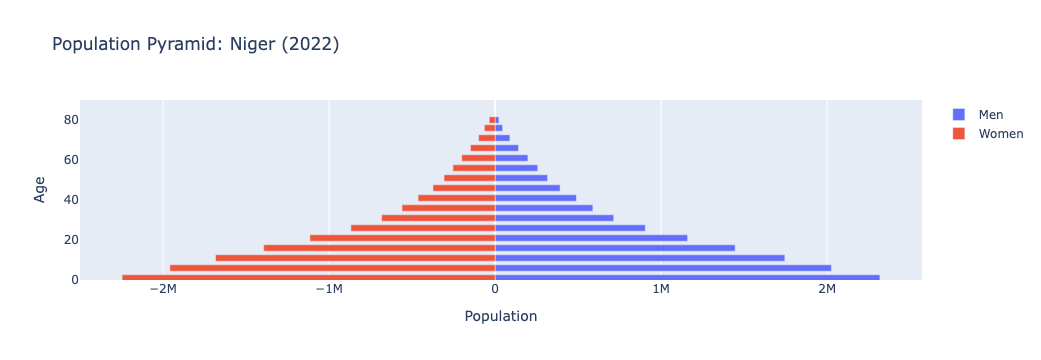

In [54]:
df_niger = wbdata.get_dataframe(
    variables,
    country="NER",
    parse_dates=True
)

#df_niger.head()

population_pyramid(
    df=df_niger,
    year="2022-01-01",
    country="Niger"
)

## Visualizations, <span style="color: red;">*Deliverable 7[C] - Other Visualizations* <a name="population-f"></span></a>
In this section, we visualize different statistics from the wbdata dataset, which would be useful for our research question.

#### Set Up

In [37]:
pd.options.plotting.backend = 'plotly'

countries = {"JPN":"Japan",
             "NER":"Niger"
            }
Japan = {"JPN":"Japan"}
Niger = {"NER":"Niger"}

#### General Information - Total Population

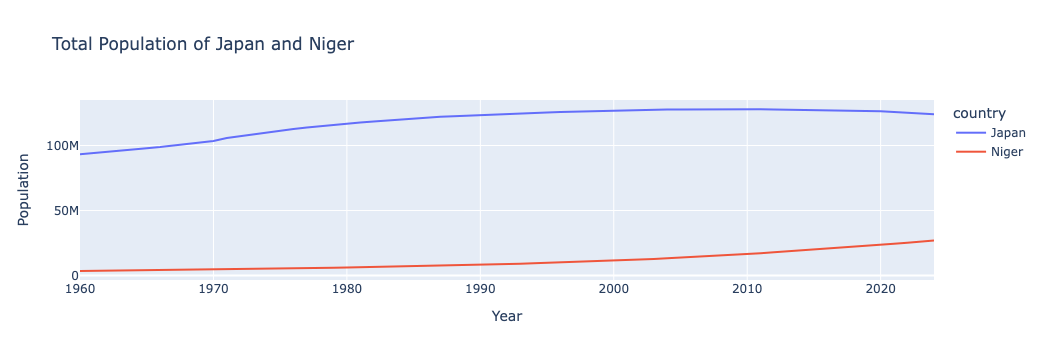

In [21]:
variable_labels = {"SP.POP.TOTL":"Population"}
df = wbdata.get_dataframe(variable_labels, country = countries, parse_dates=True).squeeze()

df = df.unstack('country')
df = df.sort_index()

df.plot(title="Total Population of Japan and Niger",
                       labels=dict(value="Population",date='Year'))

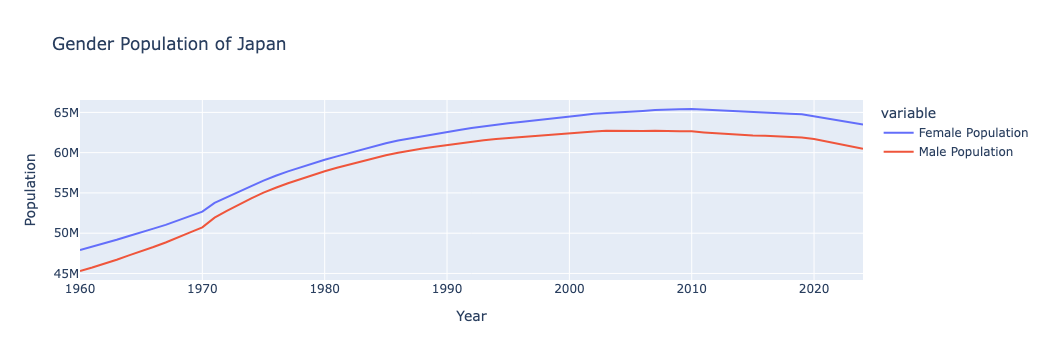

In [22]:
# Between Gender in Japan
variable_labels = {"SP.POP.TOTL.FE.IN": "Female Population",
                   "SP.POP.TOTL.MA.IN": "Male Population"}

df = wbdata.get_dataframe(variable_labels, country = Japan).squeeze()

df.index = df.index.astype(int)

df.plot(title="Gender Population of Japan",
                       labels=dict(value="Population",date='Year'))

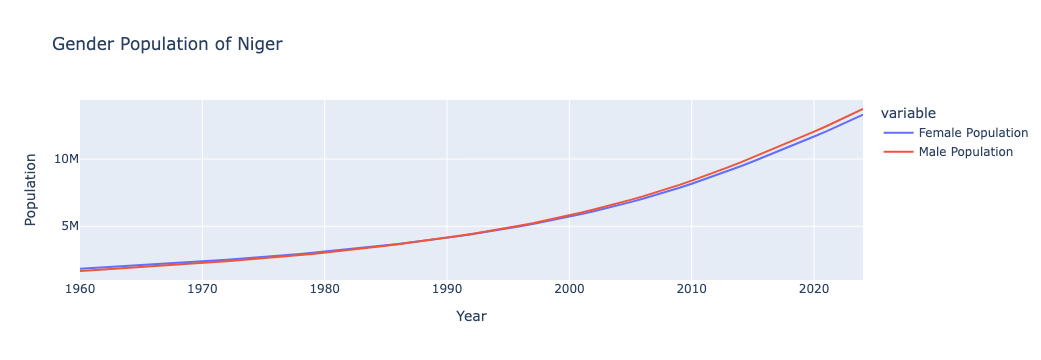

In [23]:
# Between Gender in Niger
variable_labels = {"SP.POP.TOTL.FE.IN": "Female Population",
                   "SP.POP.TOTL.MA.IN": "Male Population"}

df = wbdata.get_dataframe(variable_labels, country = Niger).squeeze()

df.index = df.index.astype(int)

df.plot(title="Gender Population of Niger",
                       labels=dict(value="Population",date='Year'))

#### Urban vs. Rural Population

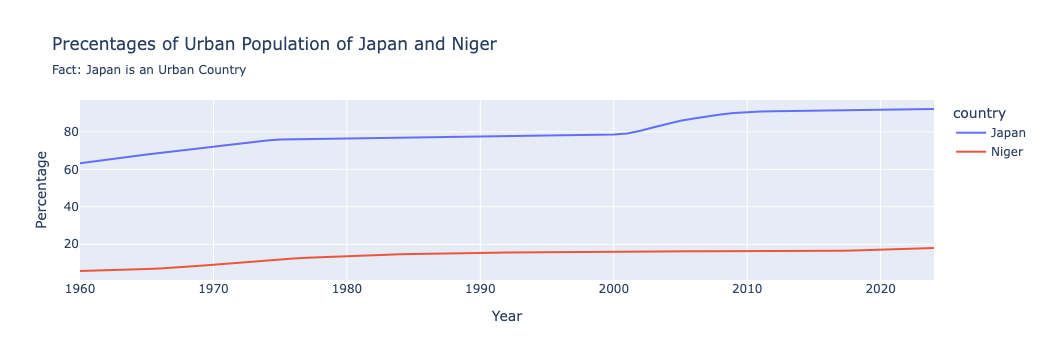

In [24]:
# Urban Population
variable_labels = {"SP.URB.TOTL.IN.ZS":"Precentages of Urban Population"}
df = wbdata.get_dataframe(variable_labels, country = countries, parse_dates=True).squeeze()

df = df.unstack('country')
df = df.sort_index()

df.plot(title="Precentages of Urban Population of Japan and Niger",
        subtitle="Fact: Japan is an Urban Country",
                       labels=dict(value="Percentage",date='Year'))

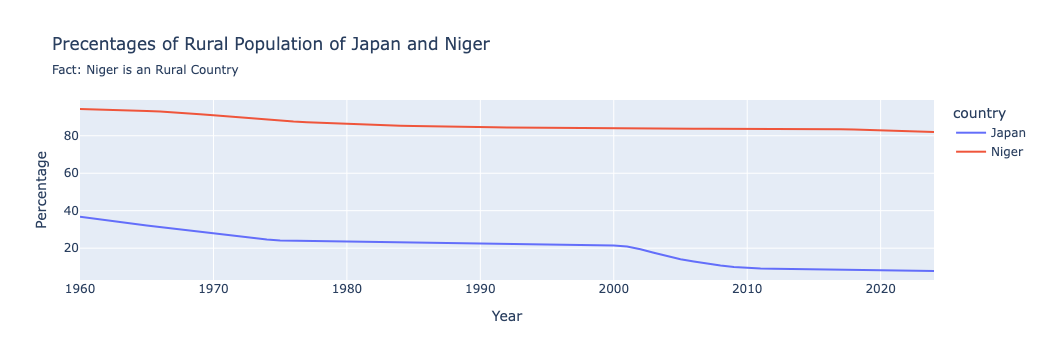

In [25]:
# Rural Population
variable_labels = {"SP.RUR.TOTL.ZS":"Precentages of Rural Population"}
df = wbdata.get_dataframe(variable_labels, country = countries, parse_dates=True).squeeze()

df = df.unstack('country')
df = df.sort_index()

df.plot(title="Precentages of Rural Population of Japan and Niger",
        subtitle="Fact: Niger is an Rural Country",
                       labels=dict(value="Percentage",date='Year'))

#### Dependency Ratios between Japan and Niger

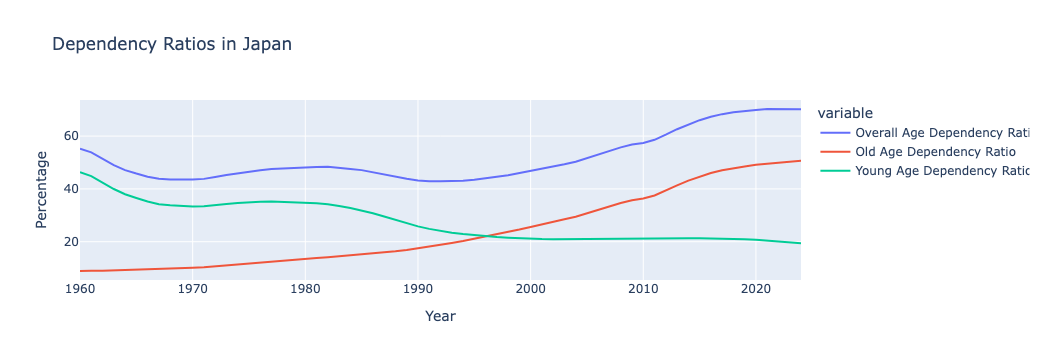

In [26]:
# Dependency Ratio in Japan
variable_labels = {"SP.POP.DPND": "Overall Age Dependency Ratio",
                   "SP.POP.DPND.OL": "Old Age Dependency Ratio",
                   "SP.POP.DPND.YG": "Young Age Dependency Ratio"}

df = wbdata.get_dataframe(variable_labels, country = Japan).squeeze()

df.index = df.index.astype(int)

df.plot(title="Dependency Ratios in Japan",
                       labels=dict(value="Percentage",date='Year'))

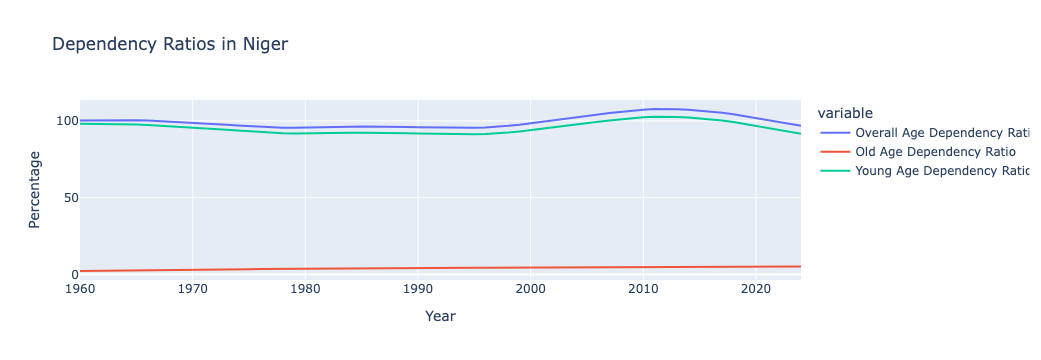

In [27]:
# Dependency Ratios in Niger
variable_labels = {"SP.POP.DPND": "Overall Age Dependency Ratio",
                   "SP.POP.DPND.OL": "Old Age Dependency Ratio",
                   "SP.POP.DPND.YG": "Young Age Dependency Ratio"}

df = wbdata.get_dataframe(variable_labels, country = Niger).squeeze()

df.index = df.index.astype(int)

df.plot(title="Dependency Ratios in Niger",
                       labels=dict(value="Percentage",date='Year'))

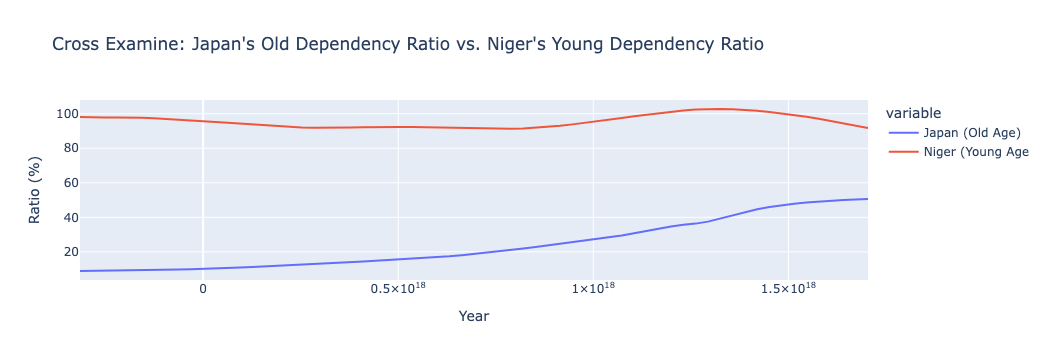

In [28]:
# Cross Examine
variable_labels = {"SP.POP.DPND.OL": "Old Age Dependency Ratio",
                   "SP.POP.DPND.YG": "Young Age Dependency Ratio"}

df = wbdata.get_dataframe(variable_labels, country=countries, parse_dates=True)
df = df.unstack('country')

comparison_df = df.loc[:, [
    ('Old Age Dependency Ratio', 'Japan'), 
    ('Young Age Dependency Ratio', 'Niger')
]]

comparison_df.index = comparison_df.index.astype(int)
comparison_df.columns = ['Japan (Old Age)', 'Niger (Young Age)'] # Rename for the legend

fig = comparison_df.plot(
    title="Cross Examine: Japan's Old Dependency Ratio vs. Niger's Young Dependency Ratio",
    labels={'value': 'Ratio (%)', 'date': 'Year'}
)

fig.show()

#### GPD per capita

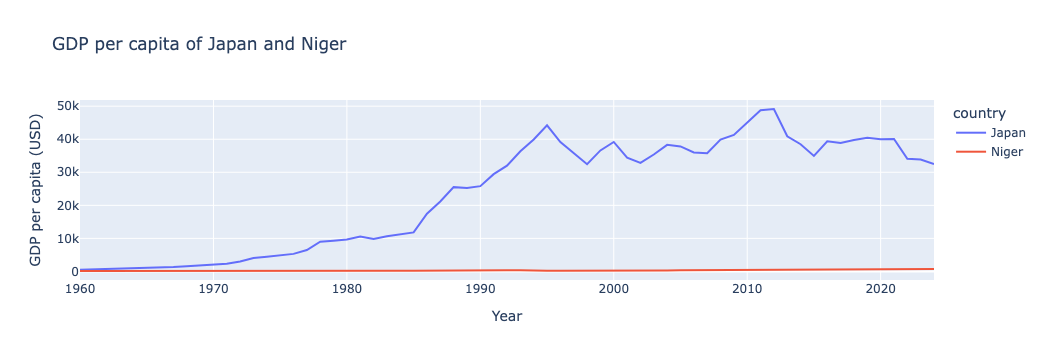

In [29]:
variable_labels = {"NY.GDP.PCAP.CD": "GDP per capita"}
df = wbdata.get_dataframe(variable_labels, country = countries, parse_dates=True).squeeze()

df = df.unstack('country')
df = df.sort_index()

df.plot(title="GDP per capita of Japan and Niger",
                       labels=dict(value="GDP per capita (USD)",date='Year'))

#### Life Expectancy

##### If this cells causes an error, Try restart the kernal and run the cell again

In [39]:
# Life Expectancy in Japan
variable_labels = {"SP.DYN.LE00.FE.IN": 'Female',
                   'SP.DYN.LE00.IN':    'Total',
                   'SP.DYN.LE00.MA.IN': 'Male'}

df = wbdata.get_dataframe(variable_labels, country = Japan).squeeze()

df.index = df.index.astype(int)

df.plot(title="Life Expectancy in Japan",
                       labels=dict(value="Life Expectancy (Years)",date='Year'))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

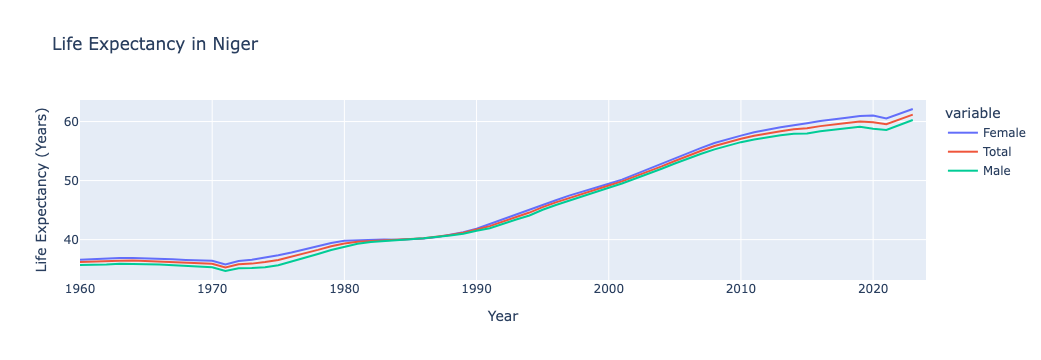

In [33]:
# Life Expectancy in Niger
variable_labels = {"SP.DYN.LE00.FE.IN": 'Female',
                   'SP.DYN.LE00.IN':    'Total',
                   'SP.DYN.LE00.MA.IN': 'Male'}

df = wbdata.get_dataframe(variable_labels, country = Niger).squeeze()

df.index = df.index.astype(int)

df.plot(title="Life Expectancy in Niger",
                       labels=dict(value="Life Expectancy (Years)",date='Year'))

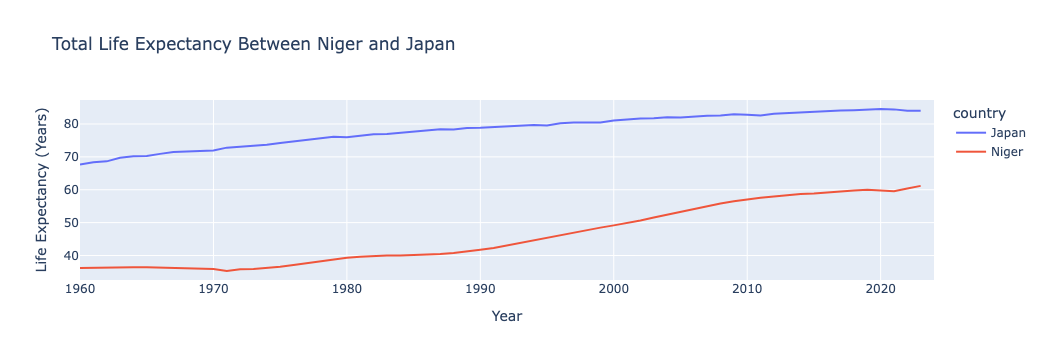

In [36]:
# Croos Examine
variable_labels = {'SP.DYN.LE00.IN':    'Total'}

df = wbdata.get_dataframe(variable_labels, country = countries, parse_dates=True).squeeze()

df = df.unstack('country')
df = df.sort_index()

df.plot(title="Total Life Expectancy Between Niger and Japan",
                       labels=dict(value="Life Expectancy (Years)",date='Year'))